In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import TimeDistributed as td
from keras.layers import Input, Conv2D, Flatten, Dense, ZeroPadding2D, Activation, concatenate
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape, UpSampling2D
from keras.models import Model

In [2]:
# Convoltuion blocks
def conv_block(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    x = Conv2D(filters=nfilters, kernel_size=(size,size) , padding=padding, kernel_initializer = 'he_normal')(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
  
def deconv_block(tensor, residual, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2))(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = concatenate([y,residual], axis = 3)
    y = conv_block(y, nfilters)
    
    return y   
     

In [3]:
def get_jnet():
    inputs = Input((224,224,3))
    
    #Contraction path
    conv1= conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=2)(conv2)

    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=2)(conv4)
   
    conv5 = conv_block(pool4, 256)
   
    #Expansion path
    up6 = deconv_block(conv5, conv4, 128)
    up7 = deconv_block(up6, conv3, 64)
    up8 = deconv_block(up7, conv2, 32)
    up9= deconv_block(up8, conv1, 16)
    
    pool_fin = MaxPooling2D(pool_size=2)(up9)
    conv10 = Conv2D(16, kernel_size=(28, 28), strides=(28, 28))(pool_fin)
    out = BatchNormalization()(conv10)
    out = Reshape((16, 16))(out)
    out = Activation('softmax')(out)

    model = Model(inputs=[inputs], outputs=[out])

    return model

In [4]:
model = get_jnet()
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [5]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        x.append(im)

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

In [6]:
def group_image(images, shuffle_arr, pieces=4):
  img = []

  new_array = [shuffle_arr[i] for i in shuffle_arr]
  print(new_array)
  new_order =  [images[i] for i in new_array]

  for i in range(pieces):
    img.append(np.concatenate(new_order[i*pieces:(i+1)*pieces], axis=1))
    
  img = np.concatenate(img, axis=0)
  return img

In [7]:
base_path = "../input/jigsaw-puzzle/Gravity Falls/puzzle_4x4/"

In [8]:
x_train, y_train = load_data(base_path, 'train', pieces=4)

In [9]:
x_val, y_val = load_data(base_path, 'valid', pieces=4)

In [10]:
weightpath = "best_weights.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks=callbacks_list)

filepath="puzzle_4x4.hdf5"
model.save(filepath)

Epoch 1/50
13/13 [==============================] - 250s 19s/step - loss: 2.1900 - sparse_categorical_accuracy: 0.3618 - val_loss: 2.6943 - val_sparse_categorical_accuracy: 0.1381
Epoch 2/50
13/13 [==============================] - 246s 19s/step - loss: 1.2235 - sparse_categorical_accuracy: 0.7777 - val_loss: 2.4557 - val_sparse_categorical_accuracy: 0.2023
Epoch 3/50
13/13 [==============================] - 244s 19s/step - loss: 0.8575 - sparse_categorical_accuracy: 0.9035 - val_loss: 2.3963 - val_sparse_categorical_accuracy: 0.2205
Epoch 4/50
13/13 [==============================] - 245s 19s/step - loss: 0.6779 - sparse_categorical_accuracy: 0.9498 - val_loss: 2.2627 - val_sparse_categorical_accuracy: 0.2688
Epoch 5/50
13/13 [==============================] - 246s 19s/step - loss: 0.5155 - sparse_categorical_accuracy: 0.9737 - val_loss: 2.1559 - val_sparse_categorical_accuracy: 0.3187
Epoch 6/50
13/13 [==============================] - 246s 19s/step - loss: 0.4189 - sparse_categorica

In [11]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss                               0.056917
sparse_categorical_accuracy        0.999757
val_loss                           0.081525
val_sparse_categorical_accuracy    0.994886
dtype: float64

In [12]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_sparse_categorical_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

Maximum accuracy: 0.9965909123420715


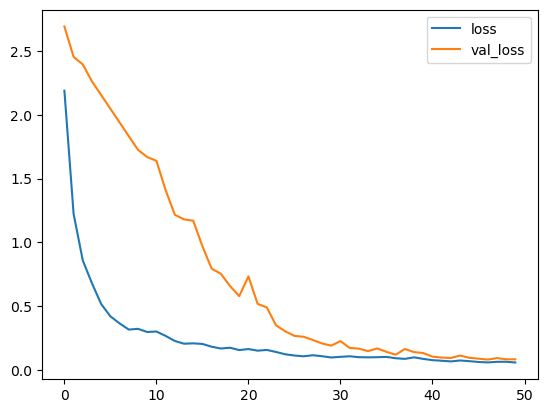

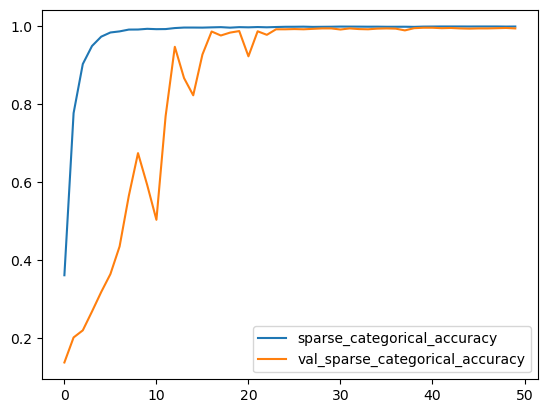

In [13]:
plot_loss_accuraccy(history)

## Test model

In [14]:
model = keras.models.load_model('puzzle_4x4.hdf5')

In [15]:
pieces=4

x_test, y_test = load_data(base_path, 'test', pieces=pieces)

In [16]:
y_pred = model.predict(x_test)
predict = [np.argmax(y, axis=1) for y in y_pred]
accuracy = np.mean(keras.metrics.categorical_accuracy(y_test.reshape(-1, 4*4), predict))

print("Accuracy on {} samples: {}%".format(len(y_pred), accuracy*100))

4/4 [==============================] - 8s 2s/step
Accuracy on 110 samples: 100.0%


In [17]:
def rearrange(im, label, pieces=4, dim=224, channel=3):
    cut_len = dim // pieces

    new_im = np.zeros((dim, dim, channel))
    for i in range(pieces):

        hor_cut = im[i * cut_len:(i + 1) * cut_len]

        for j in range(pieces):
            piece = hor_cut[:, j * cut_len:(j + 1) * cut_len]

            pos = label[i * pieces + j]
            x = pos // pieces
            y = pos % pieces

            new_im[x * cut_len:(x + 1) * cut_len, y * cut_len:(y + 1) * cut_len] = piece

    return new_im

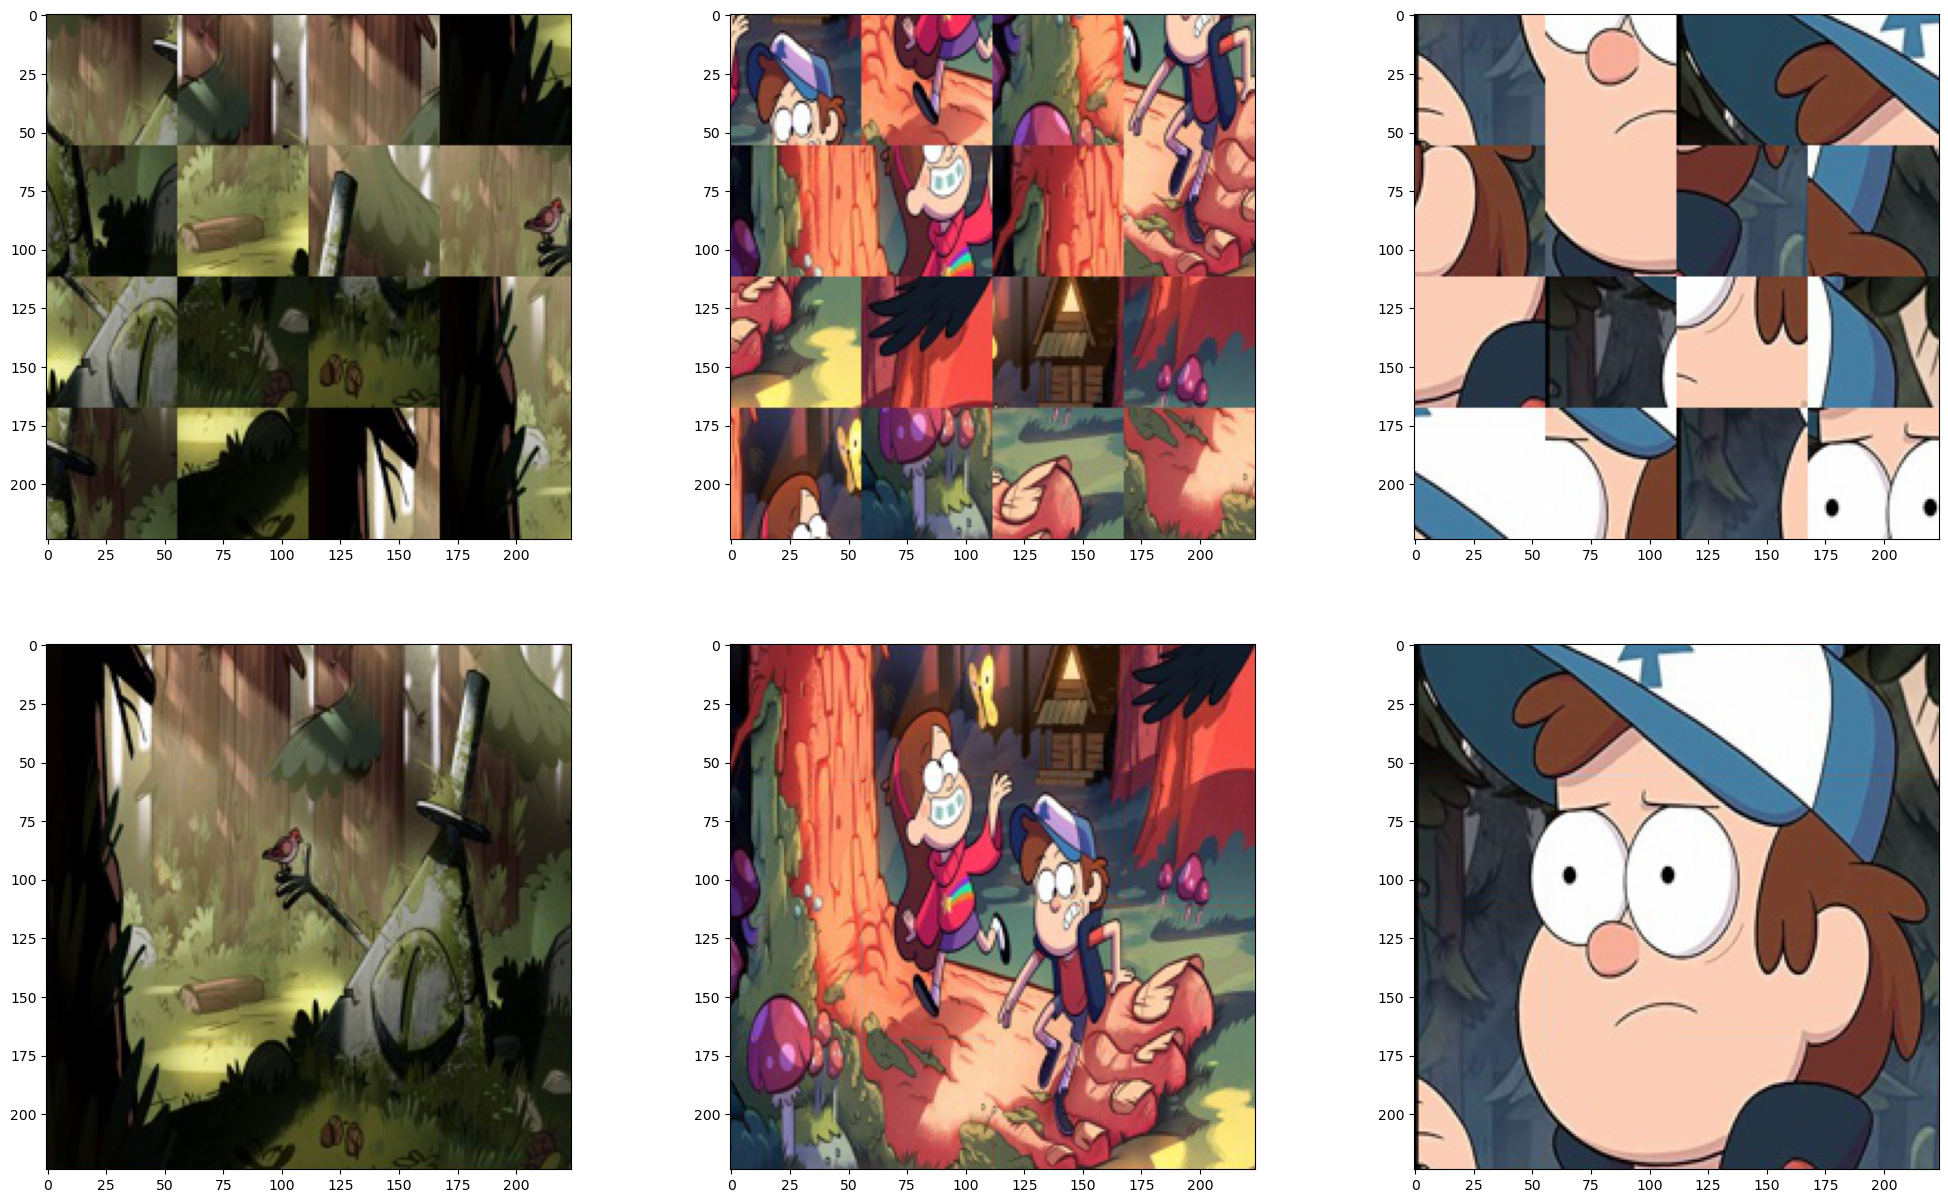

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
indexes = np.random.randint(len(x_test), size=3)

for i, idx in enumerate(indexes):
    image = x_test[idx].astype('float64')+.5
    ax[0, i].imshow(image)

    y_pred_idx = np.argmax(y_pred[idx], axis=1)
    arrange_img = rearrange(image, y_pred_idx)
    ax[1, i].imshow(arrange_img)
